To start, we mount our google drive to access the dataset that is stored in it

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


We will use data provided by Visual Geometry Group, the mjsynth dataset. This is a huge dataset total of 10 GB images.

In [ ]:
!unzip gdrive/My\Drive/mjsynth_sample.zip

In [ ]:
import os
import cv2
cv2.__version__
from google.colab.patches import cv2_imshow
import matplotlib.pyplot as plt
import numpy as np
import numpy
from os import listdir
from os.path import isfile, join
import pandas as pd

We test if the dataset has been unzipped properly by displaying an image from it

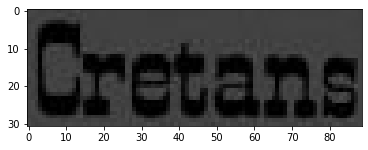

In [ ]:
mypath='/content/mjsynth_sample'
onlyfiles = [ f for f in listdir(mypath) if isfile(join(mypath,f)) ]
images = numpy.empty(len(onlyfiles), dtype=object)
for n in range(0, len(onlyfiles)):
  images[n] = cv2.imread( join(mypath,onlyfiles[n]) )

plt.imshow(images[1]) 

In [ ]:
# Import all the necessary libraries
import fnmatch
import string
import time

from keras_preprocessing.sequence import pad_sequences

from keras.layers import Dense, LSTM, Reshape, BatchNormalization, Input, Conv2D, MaxPool2D, Lambda, Bidirectional
from keras.models import Model
from keras.activations import relu, sigmoid, softmax
import keras.backend as K
import tensorflow.keras.utils
from tensorflow.keras.utils import to_categorical
from keras.callbacks import ModelCheckpoint

import matplotlib.image as mpimg
import tensorflow as tf


The images are separated into array's that contain the images path and label

In [ ]:
final_paths = []
final_texts = []

data_folder = '/content/mjsynth_sample'
for path in os.listdir(data_folder):
    final_paths.append(data_folder + "/" + path)
    final_texts.append(path.split("_")[1])

final_paths[:10], final_texts[:10]

(['/content/mjsynth_sample/18_liefer_44373.jpg',
  '/content/mjsynth_sample/435_Cretans_18040.jpg',
  '/content/mjsynth_sample/189_Vijayawada_84642.jpg',
  '/content/mjsynth_sample/418_lamaisms_43161.jpg',
  '/content/mjsynth_sample/197_CISCO_13786.jpg',
  '/content/mjsynth_sample/452_outspending_54209.jpg',
  '/content/mjsynth_sample/490_exeunt_27208.jpg',
  '/content/mjsynth_sample/491_sketchily_71264.jpg',
  '/content/mjsynth_sample/258_Cotillions_17334.jpg',
  '/content/mjsynth_sample/408_PHILISTINES_57209.jpg'],
 ['liefer',
  'Cretans',
  'Vijayawada',
  'lamaisms',
  'CISCO',
  'outspending',
  'exeunt',
  'sketchily',
  'Cotillions',
  'PHILISTINES'])

Then we create a character list

In [ ]:
### get vocab from dataset
vocab = set("".join(map(str, final_texts)))
print(sorted(vocab))

['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']


In [ ]:
from collections import Counter
Counter("".join(map(str, final_texts)))

Counter({'l': 14693,
         'i': 24247,
         'e': 31936,
         'f': 3274,
         'r': 19957,
         'C': 7202,
         't': 18281,
         'a': 21612,
         'n': 20242,
         's': 23114,
         'V': 1787,
         'j': 453,
         'y': 4643,
         'w': 2238,
         'd': 9727,
         'm': 6928,
         'I': 12696,
         'S': 14094,
         'O': 8783,
         'o': 17329,
         'u': 9212,
         'p': 6905,
         'g': 8370,
         'x': 818,
         'k': 2761,
         'c': 10014,
         'h': 6096,
         'P': 5178,
         'H': 3898,
         'L': 7997,
         'T': 10070,
         'N': 10222,
         'E': 16729,
         'A': 12188,
         'W': 1806,
         'D': 6379,
         'b': 4718,
         'Q': 350,
         'U': 4990,
         'G': 4768,
         'Z': 696,
         'M': 4745,
         'J': 518,
         'v': 2718,
         'R': 11125,
         'B': 3874,
         'z': 1340,
         'F': 2799,
         'K': 1611,
        

The characters of each word in the label is encoded into a numerical value

In [ ]:
char_list = sorted(vocab)

def encode_to_labels(txt):
    # encoding each output word into digits
    dig_lst = []
    
    for index, char in enumerate(txt):
        try:
            dig_lst.append(char_list.index(char))
        except:
            print(char)
        
    return dig_lst

In [ ]:
encode_to_labels("HELLO") #tests how a word is converted into numerical values

[17, 14, 21, 21, 24]

The labels and paths of each image is split into train and validation sets for the model to use

In [ ]:
train_final_paths = final_paths[ : int(len(final_paths) * 0.90)] #X_train
train_final_texts = final_texts[ : int(len(final_texts) * 0.90)] #X_test

val_final_paths = final_paths[int(len(final_paths) * 0.90) : ]  #Y_train
val_final_texts = final_texts[int(len(final_texts) * 0.90) : ] #Y_test

In [ ]:
len(train_final_paths), len(val_final_paths)

(47427, 5270)

In [ ]:
max_label_len = max([len(str(text)) for text in final_texts])
max_label_len

23

Data Generator to read images from large datasets on the go when they will be used for training

In [ ]:
from tensorflow.keras.utils import to_categorical, Sequence
class My_Generator(Sequence):
    
    def __init__(self, image_filenames, labels, batch_size):
        self.image_filenames, self.labels = image_filenames, labels
        self.batch_size = batch_size

    def __len__(self):
        return int(np.ceil(len(self.image_filenames) / float(self.batch_size)))

    def __getitem__(self, idx):
        
        batch_paths = self.image_filenames[idx * self.batch_size:(idx + 1) * self.batch_size]
        batch_texts = self.labels[idx * self.batch_size:(idx + 1) * self.batch_size]
        
        images = []
        training_txt = []
        train_label_length = []
        train_input_length = []

        for im_path, text in zip(batch_paths, batch_texts):
            
            try:
                text = str(text).strip()
                img = cv2.cvtColor(cv2.imread(im_path), cv2.COLOR_BGR2GRAY)   

                ### actually returns h, w
                h, w = img.shape

                ### if height less than 32
                if h < 32:
                    add_zeros = np.ones((32-h, w)) * 255
                    img = np.concatenate((img, add_zeros))
                    h = 32

                ## if width less than 128
                if w < 128:
                    add_zeros = np.ones((h, 128-w)) * 255
                    img = np.concatenate((img, add_zeros), axis=1)
                    w = 128

                ### if width is greater than 128 or height greater than 32
                if w > 128 or h > 32:
                    img = cv2.resize(img, (128, 32))

                img = np.expand_dims(img , axis = 2)

                # Normalize each image
                img = img / 255.

                images.append(img)
                training_txt.append(encode_to_labels(text))
                train_label_length.append(len(text))
                train_input_length.append(31)
            except:
                
                pass

        return [np.array(images), 
               pad_sequences(training_txt, maxlen=max_label_len, padding='post', value=len(char_list)), 
               np.array(train_input_length), 
               np.array(train_label_length)], np.zeros(len(images))

In [ ]:
train_final_paths[:1], train_final_texts[:1] 

(['/content/mjsynth_sample/18_liefer_44373.jpg'], ['liefer'])

Generates training and validation data paramaters used to train model

In [ ]:
batch_size = 256
train_generator = My_Generator(train_final_paths, train_final_texts, batch_size)
val_generator = My_Generator(val_final_paths, val_final_texts, batch_size)

In [ ]:

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)
import tensorflow.keras.backend as K

from tensorflow import keras
from tensorflow.keras import layers

from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Dense, Reshape, BatchNormalization, Input, Conv2D, MaxPool2D, Lambda, Bidirectional
from tensorflow.compat.v1.keras.layers import CuDNNLSTM
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import *
from tensorflow.keras.utils import to_categorical, Sequence
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tqdm import tqdm
from collections import Counter
from PIL import Image
from itertools import groupby




Build the Network Architecture 

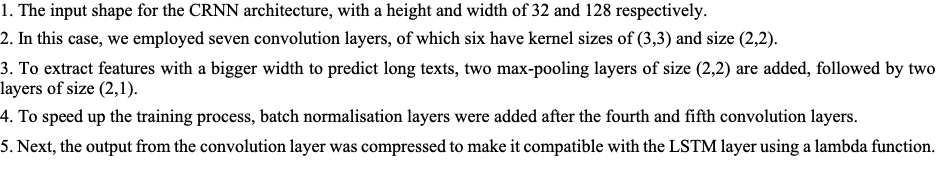

In [ ]:
# input with shape of height=32 and width=128 
inputs = Input(shape=(32, 128, 1))

conv_1 = Conv2D(16, (3,3), activation = 'relu', padding='same')(inputs)
pool_1 = MaxPool2D(pool_size=(2, 2), strides=2)(conv_1)
 
conv_2 = Conv2D(32, (3,3), activation = 'relu', padding='same')(pool_1)
pool_2 = MaxPool2D(pool_size=(2, 2), strides=2)(conv_2)

conv_3 = Conv2D(64, (3,3), activation = 'relu', padding='same')(pool_2)
conv_4 = Conv2D(64, (3,3), activation = 'relu', padding='same')(conv_3)
pool_4 = MaxPool2D(pool_size=(2, 1))(conv_4)
 
conv_5 = Conv2D(64, (3,3), activation = 'relu', padding='same')(pool_4)
# Batch normalization layer
batch_norm_5 = BatchNormalization()(conv_5)
 
conv_6 = Conv2D(64, (3,3), activation = 'relu', padding='same')(batch_norm_5)
batch_norm_6 = BatchNormalization()(conv_6)
pool_6 = MaxPool2D(pool_size=(2, 1))(batch_norm_6)
 
conv_7 = Conv2D(64, (2,2), activation = 'relu')(pool_6)
 
squeezed = Lambda(lambda x: K.squeeze(x, 1))(conv_7)
 
# bidirectional LSTM layers with units=128
blstm_1 = Bidirectional(CuDNNLSTM(128, return_sequences=True))(squeezed)
blstm_2 = Bidirectional(CuDNNLSTM(128, return_sequences=True))(blstm_1)

outputs = Dense(len(char_list) + 1, activation = 'softmax')(blstm_2)

# model to be used at test time
act_model = Model(inputs, outputs)

In [ ]:
act_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 32, 128, 1)]      0         
                                                                 
 conv2d (Conv2D)             (None, 32, 128, 16)       160       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 16, 64, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 16, 64, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 8, 32, 32)        0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 8, 32, 64)         18496 

We define a CTC Loss function that is helpful in Recognition problems

In [ ]:
labels = Input(name='the_labels', shape=[max_label_len], dtype='float32')
input_length = Input(name='input_length', shape=[1], dtype='int64')
label_length = Input(name='label_length', shape=[1], dtype='int64')

def ctc_lambda_func(args):
    y_pred, labels, input_length, label_length = args 
    return K.ctc_batch_cost(labels, y_pred, input_length, label_length)
 
loss_out = Lambda(ctc_lambda_func, 
                  output_shape=(1,), 
                  name='ctc')([outputs, labels, input_length, label_length])

#model to be used at training time
model = Model(inputs=[inputs, labels, input_length, label_length], outputs=loss_out)

We use Keras callbacks functionality to save the weights of the best model on the basis of validation loss

In [ ]:
file_path = "C_LSTM_best.hdf5"

model.compile(loss={'ctc': lambda y_true, y_pred: y_pred}, optimizer = 'adam', metrics=["accuracy"])


checkpoint = ModelCheckpoint(filepath=file_path, 
                             monitor='val_loss', 
                             verbose=1, 
                             save_best_only=True, 
                             mode='min')

callbacks_list = [checkpoint]

NVIDIA’s CUDA Python provides a driver and runtime API for existing toolkits and libraries to simplify GPU-based accelerated processing.

In [ ]:
!nvidia-smi

Sat Nov 12 14:35:26 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   44C    P0    28W /  70W |    318MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

The model is now ready to be trained

In [ ]:
epochs = 20

model_history = model.fit(train_generator, 
                    epochs = epochs,
                    steps_per_epoch = len(train_final_paths) // batch_size,
                    validation_data=val_generator,
                    validation_steps = len(val_final_paths) // batch_size,
                    verbose = 1,
                    callbacks = callbacks_list,
                    shuffle=True
                    )

Epoch 1/20
185/185 [==============================] - ETA: 0s - loss: 31.4906 - accuracy: 0.0000e+00
Epoch 1: val_loss improved from inf to 36.26032, saving model to C_LSTM_best.hdf5
185/185 [==============================] - 70s 309ms/step - loss: 31.4906 - accuracy: 0.0000e+00 - val_loss: 36.2603 - val_accuracy: 0.0000e+00
Epoch 2/20
185/185 [==============================] - ETA: 0s - loss: 27.7392 - accuracy: 0.0000e+00
Epoch 2: val_loss improved from 36.26032 to 29.56193, saving model to C_LSTM_best.hdf5
185/185 [==============================] - 50s 270ms/step - loss: 27.7392 - accuracy: 0.0000e+00 - val_loss: 29.5619 - val_accuracy: 0.0000e+00
Epoch 3/20
185/185 [==============================] - ETA: 0s - loss: 23.4058 - accuracy: 0.0000e+00
Epoch 3: val_loss improved from 29.56193 to 20.87741, saving model to C_LSTM_best.hdf5
185/185 [==============================] - 47s 254ms/step - loss: 23.4058 - accuracy: 0.0000e+00 - val_loss: 20.8774 - val_accuracy: 0.0000e+00
Epoch 4/2

In [ ]:
training_accuracy     = model_history.history['accuracy'][-1]
training_loss          = model_history.history['loss'][-1]
validation_accuracy   = model_history.history['val_accuracy'][-1]
validation_loss       = model_history.history['val_loss'][-1]
print("Training Accuracy    :", training_accuracy  )
print("Training Loss        :", training_loss)
print("Validation Accuracy  :", validation_accuracy)
print("Validation Loss      :", validation_loss)


Training Accuracy    : 0.5366758704185486
Training Loss        : 2.6803627014160156
Validation Accuracy  : 0.48164063692092896
Validation Loss      : 4.890280723571777


In [ ]:
score, acc = model.evaluate(val_generator, verbose=0)
print(score)
print(acc*100)

4.89762544631958
48.10246825218201


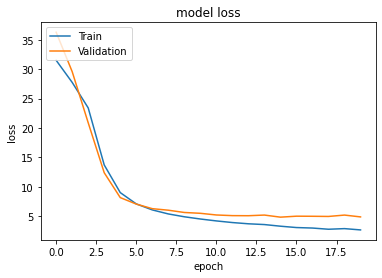

In [ ]:
plt.plot(model_history.history['loss'])
plt.plot(model_history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

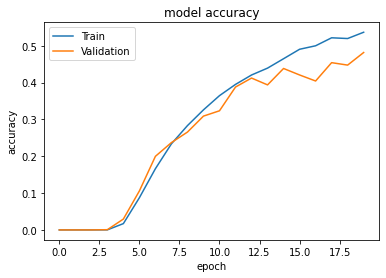

In [ ]:
plt.plot(model_history.history['accuracy'])
plt.plot(model_history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

Each image will be preprocesed before predictions can be made on it

In [ ]:
def pre_process_image(path):
    
    img = cv2.cvtColor(cv2.imread(path), cv2.COLOR_BGR2GRAY)
    ### actually returns h, w
    h, w = img.shape

    ### if height less than 32
    if h < 32:
        add_zeros = np.ones((32-h, w)) * 255
        img = np.concatenate((img, add_zeros))
        h = 32

    ## if width less than 128
    if w < 128:
        add_zeros = np.ones((h, 128-w)) * 255
        img = np.concatenate((img, add_zeros), axis=1)
        w = 128

    ### if width is greater than 128 or height greater than 32
    if w > 128 or h > 32:
        img = cv2.resize(img, (128, 32))

    
    img = np.expand_dims(img , axis = 2)

    # Normalize each image
    img = img / 255.
    
    return img

In [ ]:
act_model.load_weights('C_LSTM_best.hdf5')

The model is now to be tested. As our model predicts the probability for each class at each time step, we need to use some transcription function to convert it into actual texts. Here we will use the CTC decoder to get the output text.

In [ ]:
def predict_output(img):
    # predict outputs on validation images
    predictedText= ""
    prediction = act_model.predict(np.array([img]))
    ## shape (batch_size, num_timesteps, vocab_size)

    # use CTC decoder
    out = K.get_value(K.ctc_decode(prediction, 
                                   input_length=np.ones(prediction.shape[0]) * prediction.shape[1],
                                   greedy=True)[0][0])

    ## get the final text    
    for x in out:

        print("predicted text = ", end = '')

        for p in x:

            if int(p) != -1:
                
                print(char_list[int(p)], end = '')
                predictedText+= char_list[int(p)]
        
        print('\n')
        return  predictedText

In [ ]:
from IPython.display import display
from random import randrange

for i in range(10):
    index = randrange(len(val_final_paths))
    im = Image.open(val_final_paths[index])
    display(im)

    print("\n")

    test_img = pre_process_image(val_final_paths[index])
    print(predict_output(test_img))




1/1 [==============================] - 1s 695ms/step
predicted text = STINGRAY

STINGRAY




1/1 [==============================] - 0s 16ms/step
predicted text = Genuine

Genuine




1/1 [==============================] - 0s 16ms/step
predicted text = UNSUSTAINABLE

UNSUSTAINABLE




1/1 [==============================] - 0s 18ms/step
predicted text = kirk

kirk




1/1 [==============================] - 0s 16ms/step
predicted text = Shodaily

Shodaily




1/1 [==============================] - 0s 18ms/step
predicted text = Underwriters

Underwriters




1/1 [==============================] - 0s 19ms/step
predicted text = devoutness

devoutness




1/1 [==============================] - 0s 20ms/step
predicted text = MOUNTAN

MOUNTAN




1/1 [==============================] - 0s 25ms/step
predicted text = GOALIES

GOALIES




1/1 [==============================] - 0s 19ms/step
predicted text = NAPPED

NAPPED


Finally, we predict the text of 10 images in our validation set

An image is singled out to show the difference between the original image and the preprocessed image as well as its predicted text

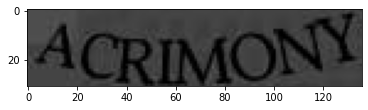

In [ ]:
imgTestPath= '/content/mjsynth_sample/100_ACRIMONY_841.jpg'
imgTest= cv2.imread(imgTestPath)
plt.imshow(imgTest)
plt.show()

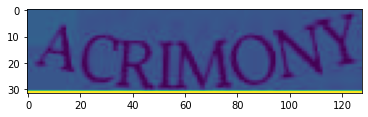

1/1 [==============================] - 0s 18ms/step
predicted text = ACRIMONY



'ACRIMONY'

In [ ]:
test_img0 = pre_process_image(imgTestPath)
plt.imshow(np.squeeze(test_img0))
plt.show()
predict_output(test_img0)

In the following section we apply 2 models, the CRNN model we just trained and Python's EasyOCR, to a dataset of never before seen Scene Text Images. The goal is to compare and contrast the prediction results of the CRNN model to the EasyOCR model. The model with the best results will be the one used in the Real-Time Video Text Recognition software.  

# CRNN 

To test how well our CRNN model works on real life Scene text images, we apply the model to a dataset of Scene text images and record it's predicted output text

In [ ]:
!unzip /content/gdrive/MyDrive/GoodQualitySTTI.zip

Archive:  /content/gdrive/MyDrive/GoodQualitySTTI.zip
   creating: GoodQualitySTTI/
  inflating: GoodQualitySTTI/KAFE_Baby_T_Café_Carlsberg.jpeg  
  inflating: __MACOSX/GoodQualitySTTI/._KAFE_Baby_T_Café_Carlsberg.jpeg  
  inflating: GoodQualitySTTI/RESTAURANT_KILLARNEY’S&IRISH_PUB .jpeg  
  inflating: __MACOSX/GoodQualitySTTI/._RESTAURANT_KILLARNEY’S&IRISH_PUB .jpeg  
  inflating: GoodQualitySTTI/NEW_TRAFFIC_SIGNALS_AHEAD.jpg  
  inflating: __MACOSX/GoodQualitySTTI/._NEW_TRAFFIC_SIGNALS_AHEAD.jpg  
  inflating: GoodQualitySTTI/Camden_Exmouth_Mews.jpeg  
  inflating: __MACOSX/GoodQualitySTTI/._Camden_Exmouth_Mews.jpeg  
  inflating: GoodQualitySTTI/MIDDLEBOROUGH.jpeg  
  inflating: __MACOSX/GoodQualitySTTI/._MIDDLEBOROUGH.jpeg  
  inflating: GoodQualitySTTI/.DS_Store  
  inflating: __MACOSX/GoodQualitySTTI/._.DS_Store  
  inflating: GoodQualitySTTI/CHELAN.jpeg  
  inflating: __MACOSX/GoodQualitySTTI/._CHELAN.jpeg  
  inflating: GoodQualitySTTI/EXIT_03_SIGN_STEALERS.jpg  
  inflating:

The dataset is loaded and its images are predicted on by the CRNN model

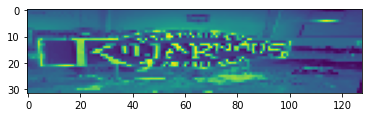

1/1 [==============================] - 0s 26ms/step
predicted text = Feospabeos

The correct Image Text is: RESTAURANT KILLARNEY’S&IRISH PUB 
The predicted Image Text is: FEOSPABEOS


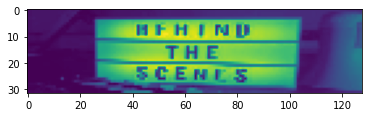

1/1 [==============================] - 0s 25ms/step
predicted text = Cal

The correct Image Text is: BEHIND THE SCENES
The predicted Image Text is: CAL


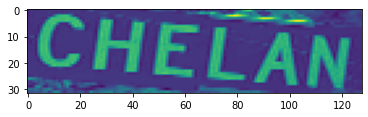

1/1 [==============================] - 0s 28ms/step
predicted text = CHELAN

The correct Image Text is: CHELAN
The predicted Image Text is: CHELAN


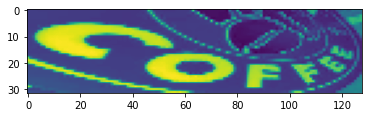

1/1 [==============================] - 0s 36ms/step
predicted text = SREIS

The correct Image Text is: COFFEE 1973
The predicted Image Text is: SREIS


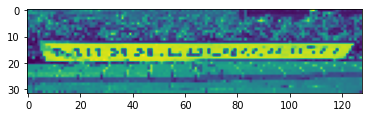

1/1 [==============================] - 0s 34ms/step
predicted text = saecs

The correct Image Text is: MIDDLEBOROUGH
The predicted Image Text is: SAECS


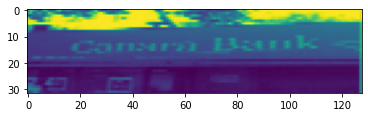

1/1 [==============================] - 0s 27ms/step
predicted text = Ste

The correct Image Text is: CANARA BANK
The predicted Image Text is: STE


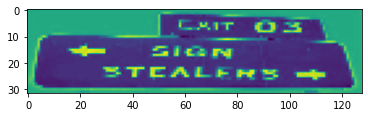

1/1 [==============================] - 0s 27ms/step
predicted text = Creniod

The correct Image Text is: EXIT 03 SIGN STEALERS
The predicted Image Text is: CRENIOD


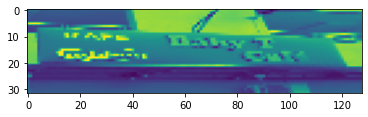

1/1 [==============================] - 0s 25ms/step
predicted text = Taeeoudsene

The correct Image Text is: KAFE BABY T CAFÉ CARLSBERG
The predicted Image Text is: TAEEOUDSENE


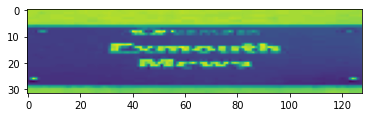

1/1 [==============================] - 0s 24ms/step
predicted text = Pen

The correct Image Text is: CAMDEN EXMOUTH MEWS
The predicted Image Text is: PEN


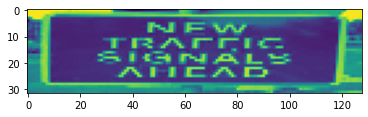

1/1 [==============================] - 0s 30ms/step
predicted text = LeSE

The correct Image Text is: NEW TRAFFIC SIGNALS AHEAD
The predicted Image Text is: LESE


The total number of correct predictions are:  1


In [ ]:
#Good Quality
mypath='/content/GoodQualitySTTI'
count=0
onlyfiles = [ f for f in listdir(mypath) if isfile(join(mypath,f)) ]
images = numpy.empty(len(onlyfiles), dtype=object)
for n in range(0, len(onlyfiles)):
  if (onlyfiles[n].endswith(".png") or onlyfiles[n].endswith(".jpg")\
        or onlyfiles[n].endswith(".jpeg")):
     images[n] = cv2.imread( join(mypath,onlyfiles[n]) )
     test_img = pre_process_image(join(mypath,onlyfiles[n])) #preprocess the image path
     plt.figure()
     plt.imshow(np.squeeze(test_img))
     plt.show()
     
     predictedText= predict_output(test_img).upper() #predict output

     imgName= onlyfiles[n].split("/")[0]
     imgName= os.path.splitext(imgName)[0]
     imgName= imgName.replace("_", " ")
     imgName= imgName.upper()
     print("The correct Image Text is: "+imgName)
     print("The predicted Image Text is: "+predictedText)

     if(imgName== predictedText):
       count += 1
print("\n")  
print("The total number of correct predictions are: ", count)

In [ ]:
!unzip /content/gdrive/MyDrive/MediumQualitySTTI.zip

Archive:  /content/gdrive/MyDrive/MediumQualitySTTI.zip
   creating: MediumQualitySTTI/
  inflating: MediumQualitySTTI/WARNING!_LOW_FLYING_AND_DEPARTING_AIRCRAFT_BLAST_CAN_CAUSE_PHYSICAL_INJURY.jpeg  
  inflating: __MACOSX/MediumQualitySTTI/._WARNING!_LOW_FLYING_AND_DEPARTING_AIRCRAFT_BLAST_CAN_CAUSE_PHYSICAL_INJURY.jpeg  
  inflating: MediumQualitySTTI/.DS_Store  
  inflating: __MACOSX/MediumQualitySTTI/._.DS_Store  
  inflating: MediumQualitySTTI/Graphic_JAVA_Mastering_the_JFC_JRD_EDITION.jpeg  
  inflating: __MACOSX/MediumQualitySTTI/._Graphic_JAVA_Mastering_the_JFC_JRD_EDITION.jpeg  
  inflating: MediumQualitySTTI/AIR_BRUSH_&_HD_MAKEUP.jpg  
  inflating: __MACOSX/MediumQualitySTTI/._AIR_BRUSH_&_HD_MAKEUP.jpg  
  inflating: MediumQualitySTTI/CHANEL.jpeg  
  inflating: __MACOSX/MediumQualitySTTI/._CHANEL.jpeg  
  inflating: MediumQualitySTTI/Pasticceria.jpeg  
  inflating: __MACOSX/MediumQualitySTTI/._Pasticceria.jpeg  
  inflating: MediumQualitySTTI/Linen_Factory.jpg  
  inflating: 

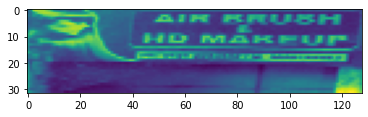

1/1 [==============================] - 0s 19ms/step
predicted text = PUt

The correct Image Text is: AIR BRUSH & HD MAKEUP
The predicted Image Text is: PUT


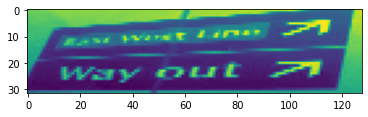

1/1 [==============================] - 0s 18ms/step
predicted text = Pts

The correct Image Text is: EAST WEST LINE WAY OUT
The predicted Image Text is: PTS


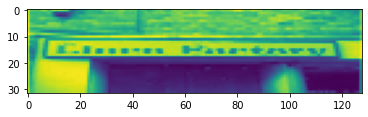

1/1 [==============================] - 0s 17ms/step
predicted text = Cn

The correct Image Text is: LINEN FACTORY
The predicted Image Text is: CN


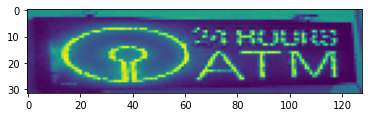

1/1 [==============================] - 0s 17ms/step
predicted text = KRRTM

The correct Image Text is: 24HOURS ATM
The predicted Image Text is: KRRTM


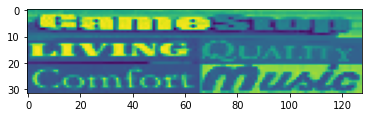

1/1 [==============================] - 0s 23ms/step
predicted text = sets

The correct Image Text is: GAMESTOP LIVING QUALITY COMFORT MUSIC
The predicted Image Text is: SETS


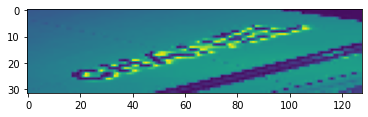

1/1 [==============================] - 0s 20ms/step
predicted text = Ss

The correct Image Text is: CHANEL
The predicted Image Text is: SS


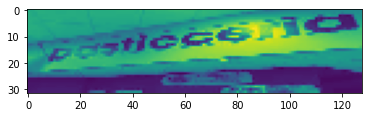

1/1 [==============================] - 0s 19ms/step
predicted text = Zeemets

The correct Image Text is: PASTICCERIA
The predicted Image Text is: ZEEMETS


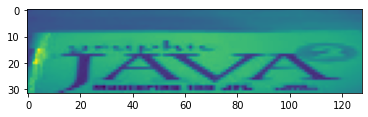

1/1 [==============================] - 0s 21ms/step
predicted text = Tas

The correct Image Text is: GRAPHIC JAVA MASTERING THE JFC JRD EDITION
The predicted Image Text is: TAS


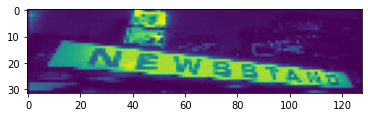

1/1 [==============================] - 0s 18ms/step
predicted text = sas

The correct Image Text is: NEWSSTAND
The predicted Image Text is: SAS


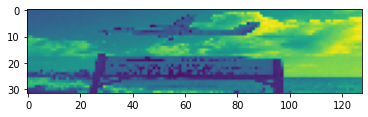

1/1 [==============================] - 0s 18ms/step
predicted text = SaE

The correct Image Text is: WARNING! LOW FLYING AND DEPARTING AIRCRAFT BLAST CAN CAUSE PHYSICAL INJURY
The predicted Image Text is: SAE


The total number of correct predictions are:  0


In [ ]:
#Medium Quality
mypath='/content/MediumQualitySTTI'
count=0
onlyfiles = [ f for f in listdir(mypath) if isfile(join(mypath,f)) ]
images = numpy.empty(len(onlyfiles), dtype=object)
for n in range(0, len(onlyfiles)):
  if (onlyfiles[n].endswith(".png") or onlyfiles[n].endswith(".jpg")\
        or onlyfiles[n].endswith(".jpeg")):
     images[n] = cv2.imread( join(mypath,onlyfiles[n]) )
     test_img = pre_process_image(join(mypath,onlyfiles[n])) #preprocess the image path
     plt.figure()
     plt.imshow(np.squeeze(test_img))
     plt.show()
     
     predictedText= predict_output(test_img).upper() #predict output

     imgName= onlyfiles[n].split("/")[0]
     imgName= os.path.splitext(imgName)[0]
     imgName= imgName.replace("_", " ")
     imgName= imgName.upper()
     print("The correct Image Text is: "+imgName)
     print("The predicted Image Text is: "+predictedText)

     if(imgName== predictedText):
       count += 1
print("\n")  
print("The total number of correct predictions are: ", count)


In [ ]:
!unzip /content/gdrive/MyDrive/BadQualitySTTI.zip

Archive:  /content/gdrive/MyDrive/BadQualitySTTI.zip
   creating: BadQualitySTTI/
  inflating: BadQualitySTTI/LOWER_FLOOR_FRESH_PICKED_DAILY_MARKET_GRILL_SEAFOOD.jpg  
  inflating: __MACOSX/BadQualitySTTI/._LOWER_FLOOR_FRESH_PICKED_DAILY_MARKET_GRILL_SEAFOOD.jpg  
  inflating: BadQualitySTTI/.DS_Store  
  inflating: __MACOSX/BadQualitySTTI/._.DS_Store  
  inflating: BadQualitySTTI/BIKES_DIRECT.jpeg  
  inflating: __MACOSX/BadQualitySTTI/._BIKES_DIRECT.jpeg  
  inflating: BadQualitySTTI/POLICE_CHECK_POST_GNA_UNIVERSITY.jpg  
  inflating: __MACOSX/BadQualitySTTI/._POLICE_CHECK_POST_GNA_UNIVERSITY.jpg  
  inflating: BadQualitySTTI/Videos_available_here.jpg  
  inflating: __MACOSX/BadQualitySTTI/._Videos_available_here.jpg  
  inflating: BadQualitySTTI/AEON_DENTAL_CENTRE.jpeg  
  inflating: __MACOSX/BadQualitySTTI/._AEON_DENTAL_CENTRE.jpeg  
  inflating: BadQualitySTTI/STARBUCKS.jpeg  
  inflating: __MACOSX/BadQualitySTTI/._STARBUCKS.jpeg  
  inflating: BadQualitySTTI/Harvesting_great_skil

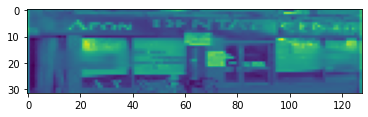

1/1 [==============================] - 0s 18ms/step
predicted text = mtate

The correct Image Text is: AEON DENTAL CENTRE
The predicted Image Text is: MTATE


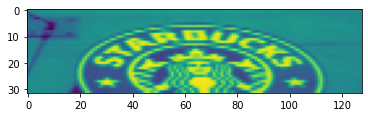

1/1 [==============================] - 0s 18ms/step
predicted text = Learses

The correct Image Text is: STARBUCKS
The predicted Image Text is: LEARSES


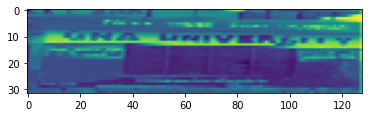

1/1 [==============================] - 0s 17ms/step
predicted text = SE

The correct Image Text is: POLICE CHECK POST GNA UNIVERSITY
The predicted Image Text is: SE


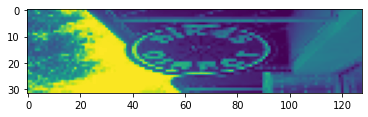

1/1 [==============================] - 0s 17ms/step
predicted text = SSEt

The correct Image Text is: BIKES DIRECT
The predicted Image Text is: SSET


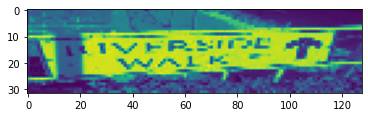

1/1 [==============================] - 0s 18ms/step
predicted text = TATATE

The correct Image Text is: RIVERSIDE WALK
The predicted Image Text is: TATATE


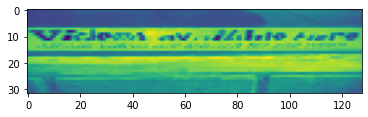

1/1 [==============================] - 0s 16ms/step
predicted text = SAETS

The correct Image Text is: VIDEOS AVAILABLE HERE
The predicted Image Text is: SAETS


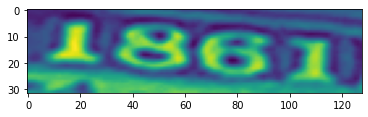

1/1 [==============================] - 0s 16ms/step
predicted text = AEST

The correct Image Text is: 1861
The predicted Image Text is: AEST


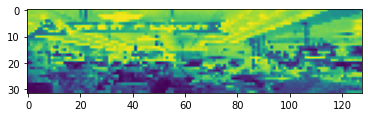

1/1 [==============================] - 0s 20ms/step
predicted text = Sast

The correct Image Text is: LOWER FLOOR FRESH PICKED DAILY MARKET GRILL SEAFOOD
The predicted Image Text is: SAST


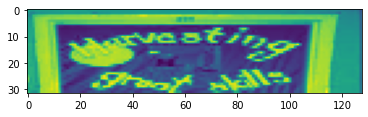

1/1 [==============================] - 0s 17ms/step
predicted text = Mstel

The correct Image Text is: HARVESTING GREAT SKILLS
The predicted Image Text is: MSTEL


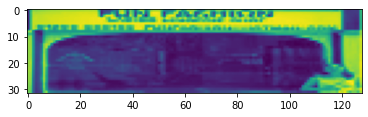

1/1 [==============================] - 0s 17ms/step
predicted text = Tead

The correct Image Text is: FUN FASHION LADIES LINGERIE SHOP 01206 368166 FUNFASHION@HOTMAIL.COM
The predicted Image Text is: TEAD


The total number of correct predictions are:  0


In [ ]:
#Bad Quality
mypath='/content/BadQualitySTTI'
count= 0
onlyfiles = [ f for f in listdir(mypath) if isfile(join(mypath,f)) ]
images = numpy.empty(len(onlyfiles), dtype=object)
for n in range(0, len(onlyfiles)):
  if (onlyfiles[n].endswith(".png") or onlyfiles[n].endswith(".jpg")\
        or onlyfiles[n].endswith(".jpeg")):
     images[n] = cv2.imread( join(mypath,onlyfiles[n]) )
     test_img = pre_process_image(join(mypath,onlyfiles[n])) #preprocess the image path
     plt.figure()
     plt.imshow(np.squeeze(test_img))
     plt.show()

     predictedText= predict_output(test_img).upper() #predict output

     imgName= onlyfiles[n].split("/")[0]
     imgName= os.path.splitext(imgName)[0]
     imgName= imgName.replace("_", " ")
     imgName= imgName.upper()
     print("The correct Image Text is: "+imgName)
     print("The predicted Image Text is: "+predictedText)

     if(imgName== predictedText):
       count += 1
print("\n")  
print("The total number of correct predictions are: ", count)




## EasyOCR

EasyOCR is built with Python and Pytorch deep learning library, having a GPU could speed up the whole process of detection.

The EasyOCR model is used to predict the texts of the same images used above to test the CRNN model. 

In [ ]:
!pip install easyocr

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 2.9 MB 15.5 MB/s 
     |████████████████████████████████| 604 kB 65.1 MB/s 
     |████████████████████████████████| 145 kB 69.0 MB/s 
     |████████████████████████████████| 47.6 MB 1.7 MB/s 
  Attempting uninstall: opencv-python-headless
    Found existing installation: opencv-python-headless 4.6.0.66
    Uninstalling opencv-python-headless-4.6.0.66:
      Successfully uninstalled opencv-python-headless-4.6.0.66


The reader specifies the language we would like to read the text in, in our case we chose 'en' which stands for English

In [ ]:
#Run Twice
import easyocr
reader= easyocr.Reader(['en'])

In [ ]:
#import libraries to detect and display easyOCR images
import PIL
from PIL import Image, ImageDraw, ImageFont

We specify a function to detect the text in an image by drawing bounding boxes around the text

In [ ]:
def draw_boxes(image, bounds, width=2, text=False):
    draw = ImageDraw.Draw(image)
    for bound in bounds:
        p0, p1, p2, p3 = bound[0]
        draw.line([*p0, *p1, *p2, *p3, *p0], fill='yellow', width=width) # random colors to better see
        if text:
          w, h = font.getsize(bound[1])
          x,y = p0[0]-10, p0[1]-10
          c = np.random.randint(100)+155
          draw.rectangle((x, y, x + w, y + h), fill=(c,c,c))
          draw.text([x,y],bound[1],fill='blue',font=font,stroke_fill='white',)

    return image

Each image is extracted and its corresponding text prediction are added to separate array's

We go through the entire dataset of Scene Text images and display them with their bounding boxes and corresponding prediction texts

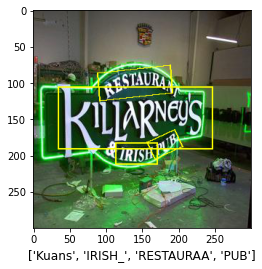

The correct Image Text is: RESTAURANT KILLARNEY’S&IRISH PUB 
The predicted Image Text is: KUANS IRISH_ RESTAURAA PUB


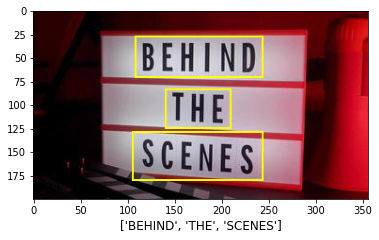

The correct Image Text is: BEHIND THE SCENES
The predicted Image Text is: BEHIND THE SCENES


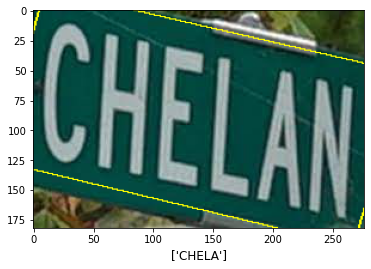

The correct Image Text is: CHELAN
The predicted Image Text is: CHELA


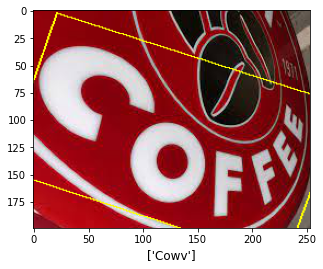

The correct Image Text is: COFFEE 1973
The predicted Image Text is: COWV


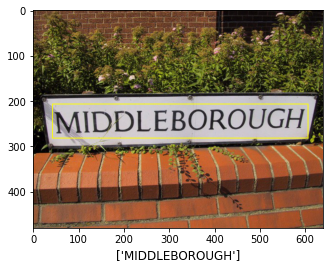

The correct Image Text is: MIDDLEBOROUGH
The predicted Image Text is: MIDDLEBOROUGH


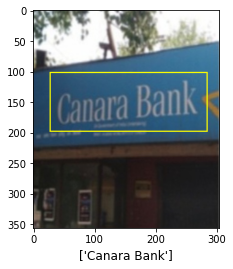

The correct Image Text is: CANARA BANK
The predicted Image Text is: CANARA BANK


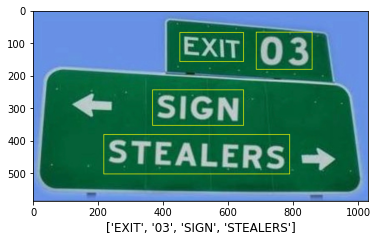

The correct Image Text is: EXIT 03 SIGN STEALERS
The predicted Image Text is: EXIT 03 SIGN STEALERS


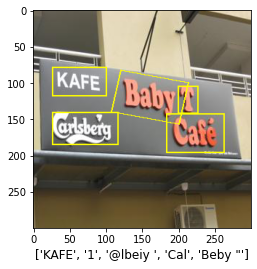

The correct Image Text is: KAFE BABY T CAFÉ CARLSBERG
The predicted Image Text is: KAFE 1 @LBEIY  CAL BEBY "


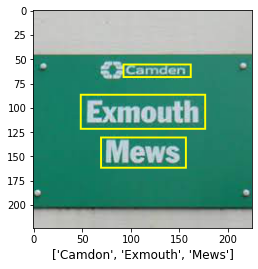

The correct Image Text is: CAMDEN EXMOUTH MEWS
The predicted Image Text is: CAMDON EXMOUTH MEWS


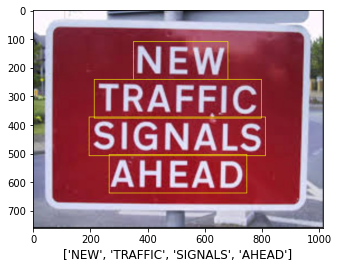

The correct Image Text is: NEW TRAFFIC SIGNALS AHEAD
The predicted Image Text is: NEW TRAFFIC SIGNALS AHEAD


The total number of correct predictions are:  5


In [ ]:
#Good Quality
mypath='/content/GoodQualitySTTI'
count=0
onlyfiles = [ f for f in listdir(mypath) if isfile(join(mypath,f)) ]
images = numpy.empty(len(onlyfiles), dtype=object)
bounds= numpy.empty(len(onlyfiles), dtype=object)
for n in range(0, len(onlyfiles)):
  if (onlyfiles[n].endswith(".png") or onlyfiles[n].endswith(".jpg")\
        or onlyfiles[n].endswith(".jpeg")):
     images[n] = PIL.Image.open( join(mypath,onlyfiles[n]) )
     bounds[n] = reader.readtext(join(mypath,onlyfiles[n]))
     plt.figure()
     plt.imshow(draw_boxes(images[n], bounds[n]))
     plt.xlabel([k[1] for k in bounds[n]], fontsize= 12)
     plt.show()
     
     # using list comprehension
     predictedText = ' '.join([k[1] for k in bounds[n]]) 
     predictedText= predictedText.upper()

     imgName= onlyfiles[n].split("/")[0]
     imgName= os.path.splitext(imgName)[0]
     imgName= imgName.replace("_", " ")
     imgName= imgName.upper()
     print("The correct Image Text is: "+imgName)
     print("The predicted Image Text is: "+predictedText)
     

     if(imgName== predictedText):
       count += 1
       
print("\n")  
print("The total number of correct predictions are: ", count)


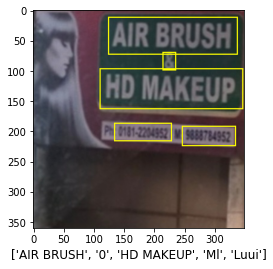

The correct Image Text is: AIR BRUSH & HD MAKEUP
The predicted Image Text is: AIR BRUSH 0 HD MAKEUP ML LUUI


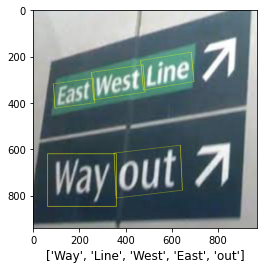

The correct Image Text is: EAST WEST LINE WAY OUT
The predicted Image Text is: WAY LINE WEST EAST OUT


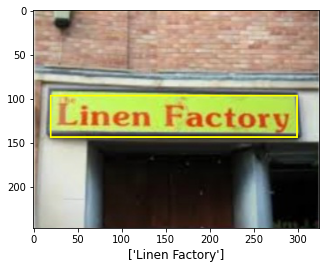

The correct Image Text is: LINEN FACTORY
The predicted Image Text is: LINEN FACTORY


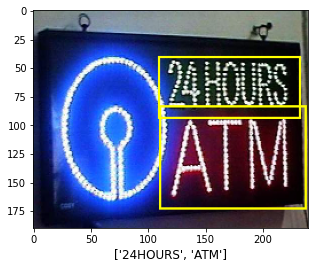

The correct Image Text is: 24HOURS ATM
The predicted Image Text is: 24HOURS ATM


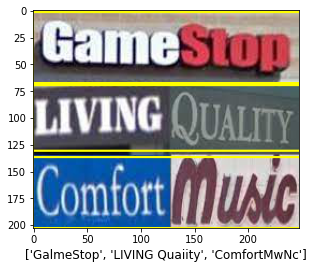

The correct Image Text is: GAMESTOP LIVING QUALITY COMFORT MUSIC
The predicted Image Text is: GALMESTOP LIVING QUAIITY COMFORTMWNC


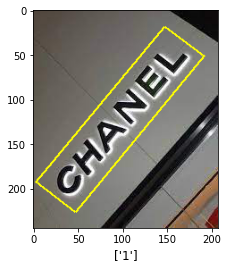

The correct Image Text is: CHANEL
The predicted Image Text is: 1


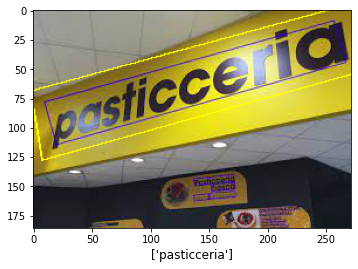

The correct Image Text is: PASTICCERIA
The predicted Image Text is: PASTICCERIA


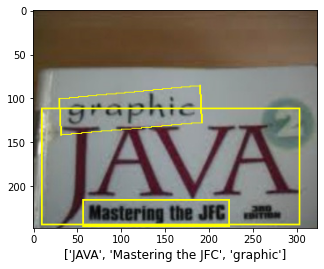

The correct Image Text is: GRAPHIC JAVA MASTERING THE JFC JRD EDITION
The predicted Image Text is: JAVA MASTERING THE JFC GRAPHIC


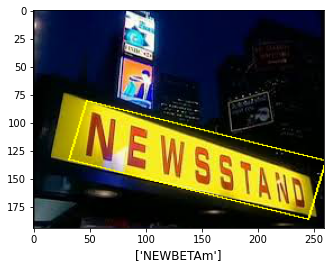

The correct Image Text is: NEWSSTAND
The predicted Image Text is: NEWBETAM


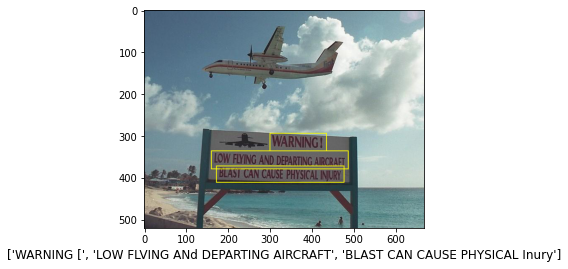

The correct Image Text is: WARNING! LOW FLYING AND DEPARTING AIRCRAFT BLAST CAN CAUSE PHYSICAL INJURY
The predicted Image Text is: WARNING [ LOW FLVING AND DEPARTING AIRCRAFT BLAST CAN CAUSE PHYSICAL INURY


The total number of correct predictions are:  3


In [ ]:
#Medium Quality

mypath='/content/MediumQualitySTTI'
count=0
onlyfiles = [ f for f in listdir(mypath) if isfile(join(mypath,f)) ]
images = numpy.empty(len(onlyfiles), dtype=object)
bounds= numpy.empty(len(onlyfiles), dtype=object)
for n in range(0, len(onlyfiles)):
  if (onlyfiles[n].endswith(".png") or onlyfiles[n].endswith(".jpg")\
        or onlyfiles[n].endswith(".jpeg")):
     images[n] = PIL.Image.open( join(mypath,onlyfiles[n]) )
     bounds[n] = reader.readtext(join(mypath,onlyfiles[n]))
     plt.figure()
     plt.imshow(draw_boxes(images[n], bounds[n]))
     plt.xlabel([k[1] for k in bounds[n]], fontsize= 12)
     plt.show()
     
     # using list comprehension
     predictedText = ' '.join([k[1] for k in bounds[n]]) 
     predictedText= predictedText.upper()

     imgName= onlyfiles[n].split("/")[0]
     imgName= os.path.splitext(imgName)[0]
     imgName= imgName.replace("_", " ")
     imgName= imgName.upper()
     print("The correct Image Text is: "+imgName)
     print("The predicted Image Text is: "+predictedText)
     

     if(imgName== predictedText):
       count += 1
       
print("\n")  
print("The total number of correct predictions are: ", count)


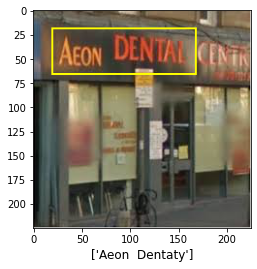

The correct Image Text is: AEON DENTAL CENTRE
The predicted Image Text is: AEON  DENTATY


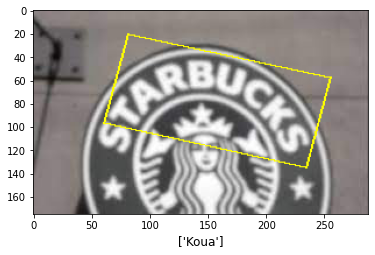

The correct Image Text is: STARBUCKS
The predicted Image Text is: KOUA


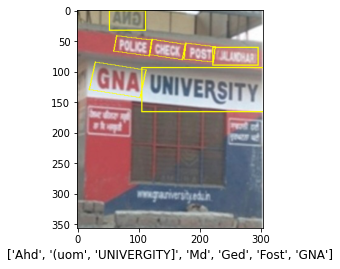

The correct Image Text is: POLICE CHECK POST GNA UNIVERSITY
The predicted Image Text is: AHD (UOM UNIVERGITY] MD GED FOST GNA


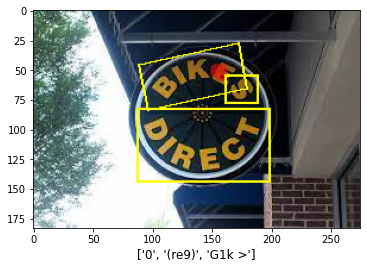

The correct Image Text is: BIKES DIRECT
The predicted Image Text is: 0 (RE9) G1K >


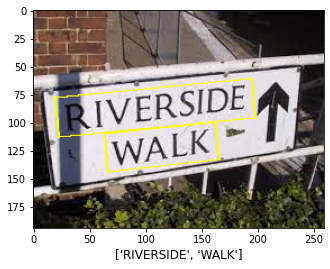

The correct Image Text is: RIVERSIDE WALK
The predicted Image Text is: RIVERSIDE WALK


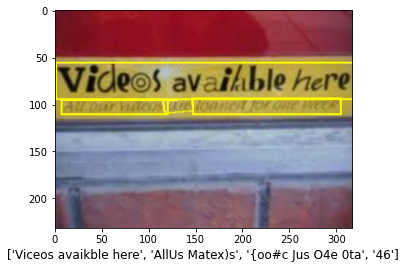

The correct Image Text is: VIDEOS AVAILABLE HERE
The predicted Image Text is: VICEOS AVAIKBLE HERE ALLUS MATEX)S {OO#C JUS O4E 0TA 46


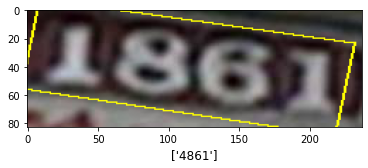

The correct Image Text is: 1861
The predicted Image Text is: 4861


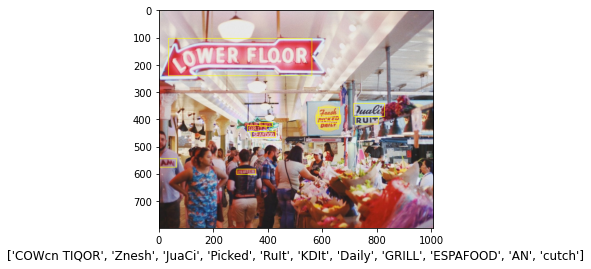

The correct Image Text is: LOWER FLOOR FRESH PICKED DAILY MARKET GRILL SEAFOOD
The predicted Image Text is: COWCN TIQOR ZNESH JUACI PICKED RUIT KDIT DAILY GRILL ESPAFOOD AN CUTCH


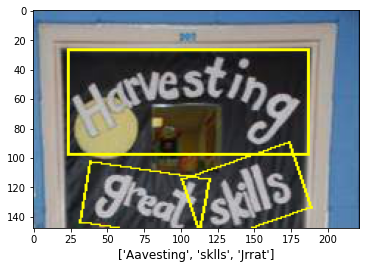

The correct Image Text is: HARVESTING GREAT SKILLS
The predicted Image Text is: AAVESTING SKLLS JRRAT


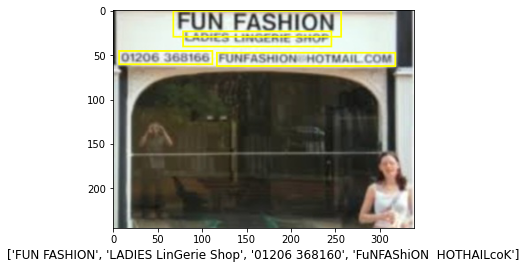

The correct Image Text is: FUN FASHION LADIES LINGERIE SHOP 01206 368166 FUNFASHION@HOTMAIL.COM
The predicted Image Text is: FUN FASHION LADIES LINGERIE SHOP 01206 368160 FUNFASHION  HOTHAILCOK


The total number of correct predictions are:  1


In [ ]:
#Bad Quality

mypath='/content/BadQualitySTTI'
count=0
onlyfiles = [ f for f in listdir(mypath) if isfile(join(mypath,f)) ]
images = numpy.empty(len(onlyfiles), dtype=object)
bounds= numpy.empty(len(onlyfiles), dtype=object)
for n in range(0, len(onlyfiles)):
  if (onlyfiles[n].endswith(".png") or onlyfiles[n].endswith(".jpg")\
        or onlyfiles[n].endswith(".jpeg")):
     images[n] = PIL.Image.open( join(mypath,onlyfiles[n]) )
     bounds[n] = reader.readtext(join(mypath,onlyfiles[n]))
     plt.figure()
     plt.imshow(draw_boxes(images[n], bounds[n]))
     plt.xlabel([k[1] for k in bounds[n]], fontsize= 12)
     plt.show()
     
     # using list comprehension
     predictedText = ' '.join([k[1] for k in bounds[n]]) 
     predictedText= predictedText.upper()

     imgName= onlyfiles[n].split("/")[0]
     imgName= os.path.splitext(imgName)[0]
     imgName= imgName.replace("_", " ")
     imgName= imgName.upper()
     print("The correct Image Text is: "+imgName)
     print("The predicted Image Text is: "+predictedText)
     

     if(imgName== predictedText):
       count += 1
       
print("\n")  
print("The total number of correct predictions are: ", count)


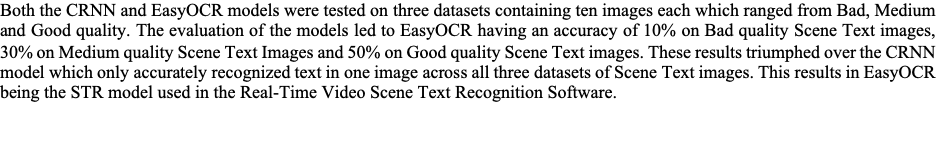